<a href="https://colab.research.google.com/github/orekhovsky/GenAI-mini-projects/blob/main/Text_generation_based_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt


In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


In [4]:
# do not change the code in the block below
# __________start of block__________
import re

# Чтение всего файла за один раз
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
with open('onegin.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.read()

# Приводим текст к нижнему регистру, заменяем табуляцию и переносы строк пробелами
text = text.lower().replace('\t', ' ').replace('\n', ' ')

# Используем регулярное выражение, чтобы разбить текст на слова и знаки препинания
words = re.findall(r"\w+|[^\w\s]", text)
print("Количество слов в корпусе:", len(words))

# Построение словаря: добавляем специальные токены <sos> и <eos>
vocab = sorted(set(words)) + ['<sos>', '<eos>']
num_tokens = len(vocab)
print("Размер словаря:", num_tokens)

token_to_idx = {token: idx for idx, token in enumerate(vocab)}
idx_to_token = {idx: token for idx, token in enumerate(vocab)}

# Кодирование текста как последовательность индексов слов
text_encoded = [token_to_idx[word] for word in words]
# __________end of block__________

Количество слов в корпусе: 29289
Размер словаря: 8408


In [5]:
# do not change the code in the block below
# __________start of block__________
import numpy as np
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length
    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

In [6]:
# your beautiful experiments here

# Вместо VanillaRNN создаём модель на базе LSTM
class WordLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super(WordLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)  # Преобразуем индексы в векторы
        output, hidden = self.lstm(x, hidden)  # LSTM возвращает выходы и скрытое состояние
        output = self.fc(output)  # Прогноз следующего токена (слова)
        return output, hidden

Epoch 1/1000, Loss: 9.0388
Epoch 2/1000, Loss: 7.5142
Epoch 3/1000, Loss: 9.5066
Epoch 4/1000, Loss: 9.5434
Epoch 5/1000, Loss: 8.4199
Epoch 6/1000, Loss: 7.7939
Epoch 7/1000, Loss: 7.3779
Epoch 8/1000, Loss: 6.9454
Epoch 9/1000, Loss: 6.3794
Epoch 10/1000, Loss: 5.8552
Epoch 11/1000, Loss: 5.4580
Epoch 12/1000, Loss: 5.2706
Epoch 13/1000, Loss: 4.9913
Epoch 14/1000, Loss: 4.6309
Epoch 15/1000, Loss: 4.2962
Epoch 16/1000, Loss: 4.0677
Epoch 17/1000, Loss: 3.8470
Epoch 18/1000, Loss: 3.7778
Epoch 19/1000, Loss: 3.4756
Epoch 20/1000, Loss: 3.3356
Epoch 21/1000, Loss: 3.3859
Epoch 22/1000, Loss: 3.0875
Epoch 23/1000, Loss: 3.0066
Epoch 24/1000, Loss: 2.8841
Epoch 25/1000, Loss: 2.7720
Epoch 26/1000, Loss: 2.8661
Epoch 27/1000, Loss: 2.6164
Epoch 28/1000, Loss: 2.5172
Epoch 29/1000, Loss: 2.4823
Epoch 30/1000, Loss: 2.5451
Epoch 31/1000, Loss: 2.4648
Epoch 32/1000, Loss: 2.2997
Epoch 33/1000, Loss: 2.3315
Epoch 34/1000, Loss: 2.1169
Epoch 35/1000, Loss: 2.0816
Epoch 36/1000, Loss: 2.0546
E

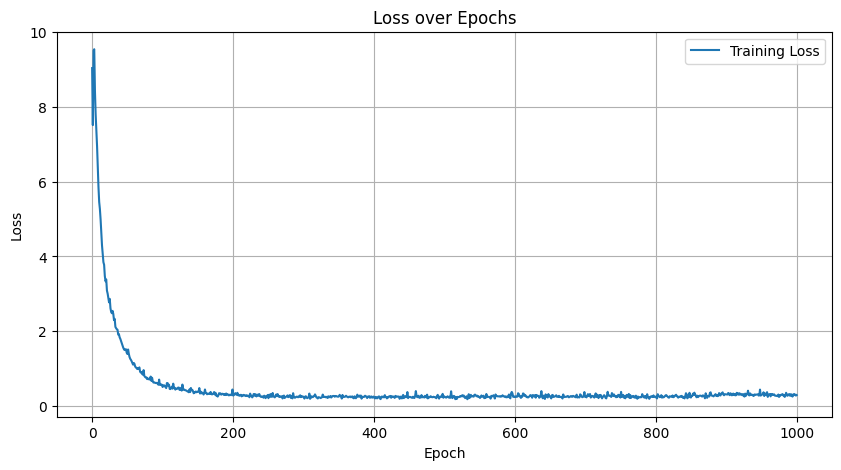

In [7]:
num_epochs = 1000
learning_rate = 0.1

# Используем модель WordLSTM для работы с последовательностями слов
model = WordLSTM(num_tokens, embedding_dim=128, hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

loss_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    batch_count = 0  # Счетчик количества батчей

    for batch in generate_chunk():
        batch_count += 1
        batch = torch.tensor(batch, dtype=torch.int64).to(device)
        input_seq = batch[:, :-1]
        target_seq = batch[:, 1:]

        optimizer.zero_grad()
        output, _ = model(input_seq)
        output = output.view(-1, num_tokens)
        loss = criterion(output, target_seq.reshape(-1))  # Приведение целевого тензора к необходимой форме
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss / batch_count)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss_history[-1]:.4f}")

# Построение графика функции потерь
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label="Training Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
def generate_sample(word_lstm, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    Генерирует текст, используя слова в качестве единиц.
    :param word_lstm: обученная модель LSTM
    :param seed_phrase: строка с начальным фрагментом, который будет продолжен
    :param max_length: максимальная длина сгенерированного текста (в словах, без учета спец. токена <sos>)
    :param temperature: коэффициент температуры для регулирования случайности при сэмплинге
    :param device: устройство для вычислений (например, 'cuda' или 'cpu')
    :return: сгенерированный текст (строка), где слова разделены пробелами
    '''
    if seed_phrase is not None:
        # Разбиваем начальную фразу на слова
        seed_tokens = seed_phrase.split()
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_tokens if token in token_to_idx]
        generated_tokens = seed_tokens[:]  # начинаем с уже заданных слов (без <sos>)
    else:
        x_sequence = [token_to_idx['<sos>']]
        generated_tokens = []

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hidden = None

    for _ in range(max_length - len(generated_tokens)):
        # Прогоняем текущую последовательность через модель
        output, hidden = word_lstm(x_sequence, hidden)
        output = output[:, -1, :]  # Берем только последний выход
        # Применяем температуру и получаем вероятностное распределение
        probabilities = torch.softmax(output / temperature, dim=-1).squeeze().cpu().data.numpy()
        next_token_idx = np.random.choice(len(probabilities), p=probabilities)
        # Если встретили токен <eos>, прекращаем генерацию
        if idx_to_token[next_token_idx] == '<eos>':
            break
        next_word = idx_to_token[next_token_idx]
        generated_tokens.append(next_word)
        # Обновляем вход для следующей итерации (только последний сгенерированный токен)
        x_sequence = torch.tensor([[next_token_idx]], dtype=torch.int64).to(device)

    return " ".join(generated_tokens)

In [18]:
seed_phrase = ' мой дядя самых честных правил'

generated_phrases = [
    generate_sample(
        model,
        seed_phrase,
        max_length=500,
        temperature=0.9  # В зависимости от качества генерации можно подобрать другое значение температуры
    ).replace('<sos>', '')
    for _ in range(3)
]

In [19]:
generated_phrases

['мой дядя самых честных правил ног вертится сердца же , хоть их в ящик не читала их . проснулся он видит ольгу пред собой . сперва взаимной разнотой они друг другу были скучны ; потом понравились ; потом съезжались каждый день верхом и скоро стали неразлучны . так люди ( первый каюсь я ) от делать нечего друзья . xiv но дружбы нет и той меж нами . все предрассудки истребя , мы почитаем всех нулями , а единицами – себя . мы все глядим в наполеоны ; двуногих тварей миллионы для нас , что с ней ? всем наотрез одно и то же ) , кто охлаждал любовь ей душно здесь он мыслит : « буду , я привык к театру , где каждый вечер убивать ? » – нимало . – « не могу понять . отселе вижу . xxxii онегин входит ; он засмеется – все хохочут ; нахмурит брови – все молчат ; так , он хозяин , это ясно : и тане уж не так ужасно он не едет в маскарад . xxvi с своей супругою дородной приехал толстый давно ли к себе ведут , целуют , нежно руки жмут , взбивают кудри ей по моде и к лицу ; уж не жаль ; онегин сохнет